問題１と問題２の回答


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

OUTPUT_fig = 'output/fig'
OUTPUT_csv = 'output/csv'
os.makedirs(OUTPUT_csv, exist_ok=True)
os.makedirs(OUTPUT_fig, exist_ok=True)

それぞれの関数の定義

In [51]:
#球のSDFクラス
class circle:
    def __init__(self, c, r):
        self.c = c
        self.r = r

    def sdf(self, x):
        return np.linalg.norm(x - self.c)-self.r, x - self.c

#ランパード反射関数
def rel_Lambert(I, x, l_point, n, k_d):
    xl = l_point - x
    r = np.linalg.norm(xl)
    l = xl/r

    return k_d*(I/r**2)*max(0, np.dot(l.T, n))

#環境反射
def rel_environment(I_a, k_a):
    return k_a*I_a

#レイマーチング関数
def raymarching(ray, forcus, sdf):
    beta = 0.01
    vec_ray = beta*(ray/np.linalg.norm(ray))
    x = forcus + vec_ray
    dist, vec_n= sdf(x)

    flag = True
    step = 0
    while -1e-1 > dist or dist > 1e-1:
        
        pre_dist = dist
        if dist > 0:
            x = x + vec_ray
            dist, vec_n = sdf(x)
        else:          
            x = x - 0.01*vec_ray
            dist, vec_n = sdf(x)
            flag = False


        if flag and pre_dist < dist: #no material is same return
            return forcus, np.zeros((3,1))

        step += 1

    return x, vec_n

各パラメータ

In [59]:
#rotation transration　x軸中心に45度回転
cos = 1/np.sqrt(2)
sin = 1/np.sqrt(2)
R = [[1, 0, 0],
     [0, cos, -sin],
     [0, sin, cos]]
R = np.array(R)
T = [0, 3, -3]
T = np.array(T).reshape((3,1))
A = np.append(R, T, axis=1)
#center of circle
w_c = [0, 0, 0]
w_c = np.array(w_c).reshape((3,1))
#circle model
model = circle(0,1)
#camera
camera = [0,0,0,1]
camera = np.array(camera).reshape((4,1))
camera = np.dot(A, camera)
#screen
screen = np.zeros((500,500))
#camera matrix
K = np.eye(3)
f_x = 500
f_y = 500
K[0,0] = f_x
K[1,1] = f_y
K[0,2] = 250
K[1,2] = 250
#parameter
I = 0.5
k_d = 1
I_a = 0.1
k_a = 0.1

レイマーチング実行

In [61]:
width = int(screen.shape[0]/2)
hight = int(screen.shape[1]/2)
for i in tqdm(range(-width, width)):
    i = i/f_x
    for j in range(-hight, hight):
        j = j/f_y
        forcus = [i, j, 1, 1]
        forcus = np.array(forcus).reshape((4,1))
        forcus_camera = forcus[:3,:]
        forcus = np.dot(A, forcus)
        
        ray = forcus - camera
        x, vec_n = raymarching(ray, forcus, model.sdf)
        if np.array_equal(forcus, x):
            vec_sc = np.dot(K, forcus_camera)
            screen[int(vec_sc[0][0]), int(vec_sc[1][0])] = 0
        else:
            vec_sc = np.dot(K, forcus_camera)
            screen[int(vec_sc[0][0]), int(vec_sc[1][0])] = rel_Lambert(I, x, camera, vec_n, k_d) + rel_environment(I_a,k_a)


100%|██████████| 500/500 [09:58<00:00,  1.20s/it]


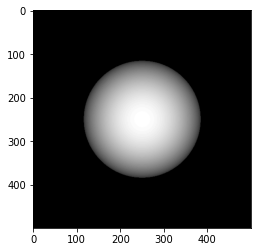

In [58]:
%matplotlib inline
plt.imshow(screen.T, 'gray')
plt.imsave(OUTPUT_fig+'/ex2.jpg', screen.T)
plt.show()